In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [15]:
#loading data set
data = pd.read_csv("wipro_stock_price.csv")
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data = data["Close"]
print(data)

Date
2022-11-07    391.500000
2022-11-09    390.950012
2022-11-10    388.899994
2022-11-11    399.700012
2022-11-14    396.549988
                 ...    
2023-10-30    382.000000
2023-10-31    381.799988
2023-11-01    380.950012
2023-11-02    383.649994
2023-11-03    383.549988
Name: Close, Length: 247, dtype: float64


In [5]:
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data.values.reshape(-1, 1))

In [6]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size, :], data[train_size:len(data), :]

In [7]:
# Create a function to generate the dataset with look-back time steps
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [8]:
# Reshape the input data to be in the format [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [9]:
# Create and compile the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(1, look_back)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
176/176 - 2s - loss: 0.0255 - 2s/epoch - 12ms/step
Epoch 2/10
176/176 - 0s - loss: 0.0085 - 383ms/epoch - 2ms/step
Epoch 3/10
176/176 - 0s - loss: 0.0063 - 325ms/epoch - 2ms/step
Epoch 4/10
176/176 - 0s - loss: 0.0053 - 315ms/epoch - 2ms/step
Epoch 5/10
176/176 - 0s - loss: 0.0048 - 295ms/epoch - 2ms/step
Epoch 6/10
176/176 - 0s - loss: 0.0045 - 331ms/epoch - 2ms/step
Epoch 7/10
176/176 - 0s - loss: 0.0045 - 299ms/epoch - 2ms/step
Epoch 8/10
176/176 - 0s - loss: 0.0041 - 314ms/epoch - 2ms/step
Epoch 9/10
176/176 - 0s - loss: 0.0037 - 300ms/epoch - 2ms/step
Epoch 10/10
176/176 - 0s - loss: 0.0040 - 298ms/epoch - 2ms/step


In [10]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 21ms/step


In [11]:
# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [12]:
# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

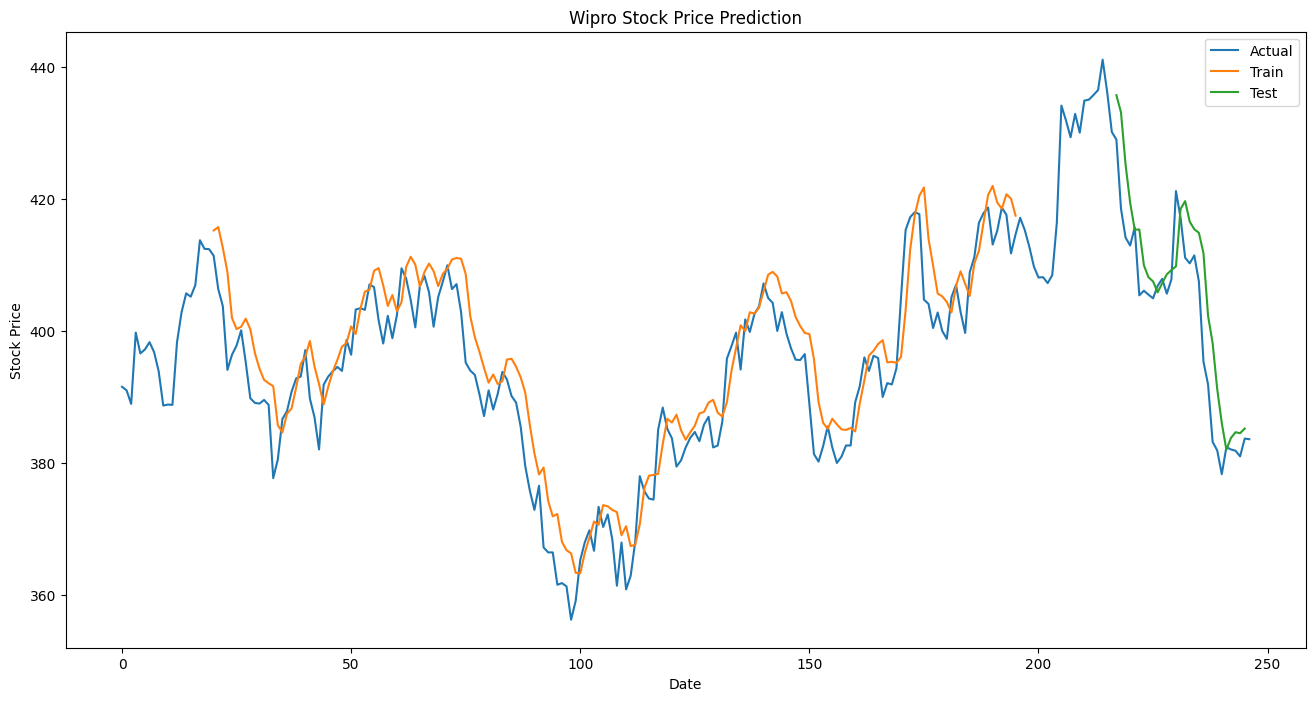

In [13]:
# Plot the predictions
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict

testPredictPlot = np.empty_like(data)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(data) - 1] = test_predict

plt.figure(figsize=(16, 8))
plt.title("Wipro Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["Actual", "Train", "Test"])
plt.show()